In [1]:
!wget https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-train-transliterated.csv -O train.csv
!wget https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-dev-transliterated.csv -O test.csv

--2019-12-16 11:15:06--  https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-train-transliterated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5650505 (5.4M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   5.39M  --.-KB/s    in 0.06s   

2019-12-16 11:15:06 (85.4 MB/s) - ‘train.csv’ saved [5650505/5650505]

--2019-12-16 11:15:08--  https://raw.githubusercontent.com/HSE-CROSS-LING-DL/cma/master/data/trk-uncovered-dev-transliterated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response...

In [0]:
import pandas as pd
from tqdm import tqdm

In [0]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
data.shape

(79228, 5)

In [7]:
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(79228, 5)

In [8]:
test = test.dropna()
test = test.reset_index(drop=True)
test.shape

(1245, 5)

In [9]:
data['pos'].value_counts() * 100 / data.shape[0]

NOUN    53.789064
VERB    40.141112
ADJ      5.231736
ADV      0.838088
Name: pos, dtype: float64

In [10]:
data.head()

,lang,word,lemma,pos,morph
0,tat,казак,казак,NOUN,Case=Nom
1,tur,мuамеле,мuамеле,NOUN,Case=Nom
2,tat,заманы,заман,NOUN,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3"
3,tur,конuт,конuт,NOUN,Case=Nom
4,tur,корuмасы,корu,VERB,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3..."


POS-теги:

In [0]:
pos_mapper = {pos: n for n, pos in enumerate(data.pos.unique())}
data['pos_num'] = data.pos.map(pos_mapper)
test['pos_num'] = test.pos.map(pos_mapper)

In [13]:
data.head()

,lang,word,lemma,pos,morph,pos_num
0,tat,казак,казак,NOUN,Case=Nom,0
1,tur,мuамеле,мuамеле,NOUN,Case=Nom,0
2,tat,заманы,заман,NOUN,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3",0
3,tur,конuт,конuт,NOUN,Case=Nom,0
4,tur,корuмасы,корu,VERB,"Case=Nom|Number[psor]=Sing,Plur|Person[psor]=3...",1


In [14]:
test.head()

,lang,word,lemma,pos,morph,pos_num
0,crh,егленcелер,егленcе,NOUN,Case=Nom|Number=Plur,0
1,crh,сüргüнликниң,сüргüнлик,NOUN,Case=Gen,0
2,crh,монархийада,монархийа,NOUN,Case=Loc,0
3,crh,кöстергенлери,кöстер,VERB,"Case=Nom|Number=Plur|Number[psor]=Sing,Plur|Pe...",1
4,crh,öксüз,öксüз,NOUN,Case=Nom,0


Data Loader

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
char2index = {'PAD': 0}
MAX_LEN = 0
lengths = []

for word in tqdm(data.word):
  l = len(word)
  lengths.append(l)
  if l > MAX_LEN:
    MAX_LEN = l
  
  for char in word:
    if char not in char2index:
      char2index[char] = len(char2index)

100%|██████████| 79228/79228 [00:00<00:00, 653945.48it/s]


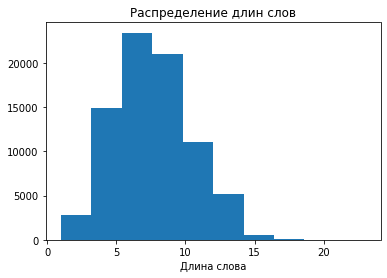

In [17]:
from matplotlib import pyplot as plt

plt.title('Распределение длин слов')
plt.xlabel('Длина слова')
plt.hist(lengths)
plt.show()

In [0]:
class LoadData(Dataset):
    
    def __init__(self, x_data, y_data, char2index=char2index, sequence_length=16,\
                 pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        self.char2index = char2index

        self.sequence_length = sequence_length
        self.pad_token = pad_token
        self.pad_index = self.char2index[self.pad_token]

        self.load(x_data, verbose=verbose)

    def preprocess(self, word):
      return [c for c in word]

    def indexing(self, chars):
        return [self.char2index[char] for char in chars if char in self.char2index]

    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for word in data_iterator:
            chars = self.preprocess(word)
            indexed_chars = self.indexing(chars)
            self.x_data.append(indexed_chars)

    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
          sequence = sequence[:self.sequence_length]
        elif len(sequence) < self.sequence_length:
          sequence = sequence + [self.pad_index] * (self.sequence_length - len(sequence))
        return sequence

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]
        
        return x, y

In [20]:
train_dataset = LoadData(data.word, data.pos_num)

Loading data: 100%|██████████| 79228/79228 [00:00<00:00, 299761.78it/s]


In [21]:
test_dataset = LoadData(test.word, test.pos_num)

Loading data: 100%|██████████| 1245/1245 [00:00<00:00, 153427.60it/s]


In [0]:
train_data_loader = DataLoader(train_dataset, batch_size=64)
test_data_loader = DataLoader(test_dataset, batch_size=64)

Модель

In [0]:
from torch import nn
import numpy as np
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [27]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.unique(data.pos_num), data.pos_num)
weights = torch.FloatTensor(weights)
weights

tensor([ 0.4648,  0.6228,  4.7785, 29.8298])

In [0]:
class POSTagger(nn.Module):

  def __init__(self, embedding_dim=64, vocab_size=len(char2index), hidden_dim=64, 
               ngrams=[2,3,4], seq_len=16, n_classes=4, keep_proba=0.5):

    super().__init__()

    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim

    self.dropout = nn.Dropout(p=keep_proba)

    self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, \
                                        embedding_dim=self.embedding_dim)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, 
                                          out_channels=self.hidden_dim, 
                                          kernel_size=n) for n in ngrams])
    
    self.pooling = nn.ModuleList([nn.MaxPool1d(kernel_size=seq_len-n+1) for n in ngrams])
    self.linear = nn.Linear(in_features=len(ngrams) * self.hidden_dim, out_features=n_classes)

  def forward(self, x):
    x = self.embedding_layer(x).transpose(1,2)
    conved = [conv(x) for conv in self.convs]
    pooled = [pool(conv).squeeze(-1) for pool, conv in zip(self.pooling, conved)]
    cat = self.dropout(torch.cat(pooled, 1))

    return self.linear(cat)

In [0]:
model = POSTagger()

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(params=model.parameters())

In [30]:
epochs = 15
losses = []
best_test_loss = 10.

acc, macros, prec, rec = [], [], [], []
for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_data_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_data_loader:     
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_data_loader:

      with torch.no_grad():
            
        pred = model(x)

        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())
        test_pred_class.append(np.argmax(pred, axis=1))

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()
    
    accuracy = accuracy_score(test_targets, test_pred_class)
    precision = precision_score(test_targets, test_pred_class, average='macro')
    recall = recall_score(test_targets, test_pred_class, average='macro')
    f1 = f1_score(test_targets, test_pred_class, average='macro')

    acc.append(accuracy)
    macros.append(f1)
    prec.append(precision)
    rec.append(recall)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('Test: accuracy - {:.3f}, precision - {:.3f}, recall - {:.3f}, f1 macro - {:.3f}'.format(accuracy, precision, recall, f1))

    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   1%|          | 768/79228 [00:00<00:19, 4096.27it/s, train_loss=1.1]


Losses: train - 1.175, test - 1.125
Test: accuracy - 0.627, precision - 0.442, recall - 0.457, f1 macro - 0.407


Epoch 3:   1%|          | 768/79228 [00:00<00:17, 4449.81it/s, train_loss=0.995]


Losses: train - 1.020, test - 1.070
Test: accuracy - 0.630, precision - 0.456, recall - 0.528, f1 macro - 0.417


Epoch 3: 100%|██████████| 79228/79228 [00:19<00:00, 4153.51it/s, train_loss=0.943]



Losses: train - 0.955, test - 1.099
Test: accuracy - 0.663, precision - 0.459, recall - 0.493, f1 macro - 0.422
Early stopping


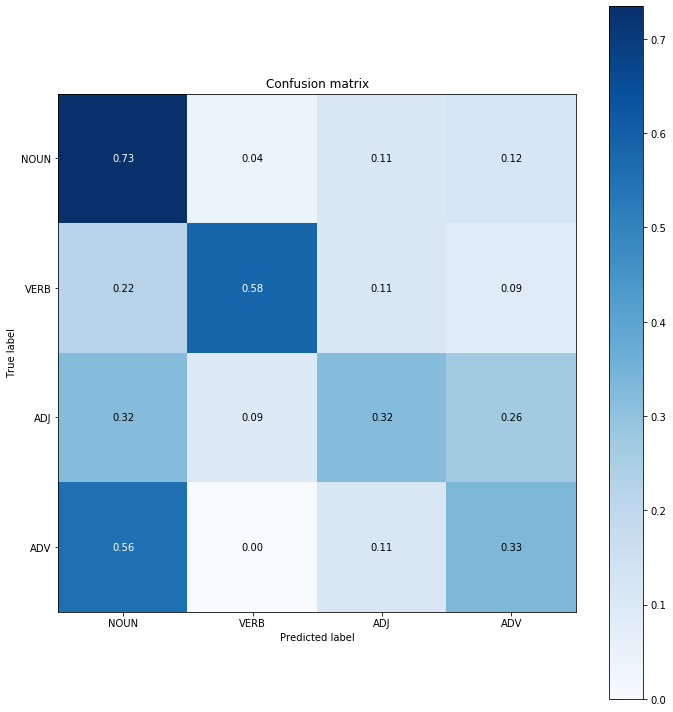

In [31]:
cm = confusion_matrix(test_targets, test_pred_class)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

classes = unique_labels(test_targets, test_pred_class)
pos_mapper = sorted(pos_mapper.items(), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=[k[0] for k in pos_mapper], yticklabels=[k[0] for k in pos_mapper],
       title='Confusion matrix', ylabel='True label', xlabel='Predicted label')

fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()


plt.show()